In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import libraries

In [2]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.1 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# plt.style.use('dark_background')

from statsmodels.tsa.stattools import adfuller  # kiểm tra chuỗi có tính dừng không -> có phụ thuộc vào thời gian chạy không?
from statsmodels.tsa.seasonal import seasonal_decompose   # phân tích -> thành phần chuỗi gốc, thành phần xu hướng, thành phần mùa vụ và thành phần nhiễu

from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Eval Function

In [4]:
def eval(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val)
  print('MAE: ', val_mae)

  val_ape = np.abs((val - pred_val) / val)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_mse = mean_squared_error(val, pred_val)
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

In [5]:
def test_stationarity(timeseries):

    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='yellow', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC') # tự động lựa chọn số lượng lag tối ưu dựa trên tiêu chí AIC ->
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

## Data

In [6]:
# 2. Đọc file csv
# company_csv = '/content/drive/MyDrive/Colab Notebooks/Datacrawl/IMP.csv'
# company_csv = '/content/drive/MyDrive/Colab Notebooks/Datacrawl/OPC.csv'
company_csv = '/content/drive/MyDrive/Colab Notebooks/Datacrawl/VMD.csv'
data = pd.read_csv(company_csv)
data

,Unnamed: 0,time,open,high,low,close,volume,ticker
0,0,2014-01-02,5980,6240,5980,6240,50,VMD
1,1,2014-01-03,6240,6240,6240,6240,100,VMD
2,2,2014-01-06,6340,6340,6340,6340,860,VMD
3,3,2014-01-07,6340,6340,6340,6340,0,VMD
4,4,2014-01-08,6090,6340,6090,6340,200,VMD
...,...,...,...,...,...,...,...,...
2472,2472,2023-12-04,20300,20300,19700,20300,238300,VMD
2473,2473,2023-12-05,20300,20900,19750,19900,62700,VMD
2474,2474,2023-12-06,20300,20600,20100,20150,51500,VMD
2475,2475,2023-12-07,20150,20300,20000,20150,41100,VMD


### Choose X

## Train, test, valid

In [7]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:1:2
df = pd.read_csv(company_csv)
df = df[['close']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets 7:2:1
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [8]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['close'])

## Build model

### Choose p, q, d

In [9]:
model_autoARIMA = auto_arima(y_train,start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True,
                      exogenous= data[['high','open','low']][:len(y_train)])

model_autoARIMA.summary()

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=38564.584, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=26431.326, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=26419.228, Time=0.26 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=26433.506, Time=0.25 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=26423.248, Time=0.29 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=26434.642, Time=0.09 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=26431.622, Time=1.93 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=26424.243, Time=1.15 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 4.631 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1733
Model:               SARIMAX(2, 0, 1)   Log Likelihood              -13205.614
Date:                Sat, 16 Dec 2023   AIC                          26419.228
Time:                        15:07:47   BIC                          26441.059
Sample:                             0   HQIC                         26427.302
                               - 1733                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6543      0.069     24.107      0.000       1.520       1.789
ar.L2         -0.6543      0.069     -9.536      0.000      -0.789      -0.520
ma.L1         -0.7471      0.060    -12.355      0.000      -0.866      -0.629
sigma2      2.444e+05   1.27e-09   1.93e+14      0.000    2.44e+05    2.44e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               244.64
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               1.72   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.54e+30. Standard errors may be unstable.
"""

### Build model

In [10]:
model = ARIMA(y_train, order=(2,0,1),exog=data[['high','open','low']][:len(y_train)]).fit()
model.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1733
Model:                 ARIMA(2, 0, 1)   Log Likelihood              -11864.091
Date:                Sat, 16 Dec 2023   AIC                          23744.181
Time:                        15:07:48   BIC                          23787.842
Sample:                             0   HQIC                         23760.329
                               - 1733                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         47.8730     36.517      1.311      0.190     -23.699     119.445
high           0.8246      0.010     78.670      0.000       0.804       0.845
open          -0.5391      0.011    -48.831      0.000      -0.561      -0.517
low            0.7116      0.013     56.519      0.000       0.687       0.736
ar.L1          0.0305     43.896      0.001      0.999     -86.004      86.065
ar.L2          0.0023      2.679      0.001      0.999      -5.248       5.253
ma.L1          0.0305     43.896      0.001      0.999     -86.005      86.066
sigma2      5.186e+04    887.330     58.442      0.000    5.01e+04    5.36e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             24646.48
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.20   Skew:                            -1.59
Prob(H) (two-sided):                  0.03   Kurtosis:                        21.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Eval

In [11]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['close'])
y_pred = model.predict(start=int(x_test[0]), end=int(len(x_test)+x_test[0]-1),exog=data[['high','open','low']][int(x_test[0]):int(len(x_test)+x_test[0])])


x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['close'])
y_pred_val =  model.predict(start=int(x_val[0]), end=int(len(x_val)+x_val[0]-1),exog=data[['high','open','low']][len(x_train):(int(len(x_val)+x_val[0]))])

In [12]:
eval(y_test,y_pred,y_val,y_pred_val)

** Testing **
MAE:  309.27102803961554
MAPE:  1.1725812108064244
RMSE:  474.06795240107823

** Validate **
MAE:  211.8642828646263
MAPE:  0.9833511047008069
RMSE:  290.2253154556732


## Forecast

In [13]:
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
# exogg = data[['high','open','low']][last_index-447:last_index].values.reshape(1341, 0)
# 1332 - 444 ; 1341 - 447; 1338 - 446
y_next_30_days = model.predict(start=int(x_next_30_days[0]), end=int(len(x_next_30_days)+x_next_30_days[0]-1),exog= data[['high','open','low']][last_index-774:last_index])
#data[['high','open','low']][last_index-447:last_index]

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
2477    18501.520187
2478    17916.895452
2479    17083.663717
2480    16509.125032
2481    16442.831407
2482    16145.876344
2483    16031.389238
2484    15595.310763
2485    15503.721078
2486    15828.202580
2487    16822.599384
2488    16799.478597
2489    16485.863342
2490    16556.799663
2491    16533.682323
2492    16300.285333
2493    16612.670325
2494    16818.527198
2495    16612.086137
2496    16821.211091
2497    16962.953060
2498    16601.584160
2499    16302.037746
2500    16576.002845
2501    17423.729730
2502    18992.146368
2503    19861.396059
2504    20391.748112
2505    20393.407982
2506    20155.732565
Name: predicted_mean, dtype: float64


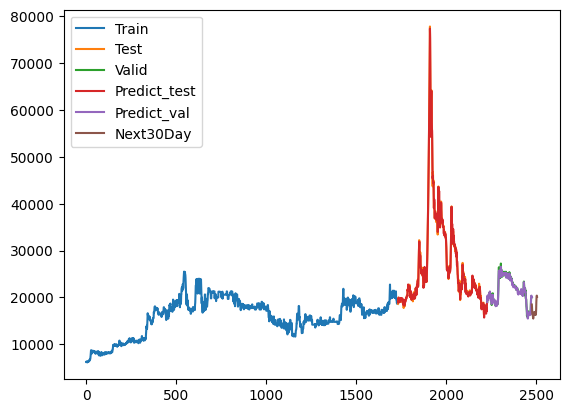

In [14]:
plt.plot(train_data.index, train_data['close'])
plt.plot(test_data.index, test_data['close'])
plt.plot(val_data.index, val_data['close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Valid', 'Predict_test','Predict_val','Next30Day'])
plt.show()